In [1]:
import numpy as np
from itertools import product

from qiskit import Aer, ClassicalRegister, execute, QuantumRegister, transpile
from qiskit.circuit import QuantumCircuit
from qiskit.extensions import RYGate, XGate
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_histogram

from banded_circulant_matrix import block_encoding, signal_oracle, unitary_iterate

## $O_C$ oracle
$$U_L | j \rangle = | \mathrm{mod}(j + 1, N) \rangle$$

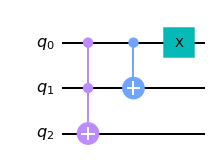

In [2]:
ul = QuantumCircuit(3)
ul.ccx(0, 1, 2)
ul.cx(0, 1)
ul.x(0)
ul.draw("mpl", fold=-1)

In [3]:
backend = Aer.get_backend("unitary_simulator")
job = execute(ul, backend)
result = job.result()
print(result.get_unitary(ul, decimals=3))

Operator([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))


$$U_R | j \rangle = | \mathrm{mod}(j - 1, N) \rangle$$

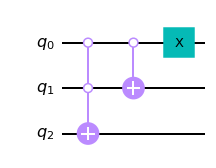

In [4]:
ur = QuantumCircuit(3)
ur.ccx(0, 1, 2, ctrl_state="00")
ur.cx(0, 1, ctrl_state="0")
ur.x(0)
ur.draw("mpl", fold=-1)

In [5]:
job = execute(ur, backend)
result = job.result()
print(result.get_unitary(ur, decimals=3))

Operator([[0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))


## Banded circulant matrix
Block encoding of $A / 4$, where
$$
A = \begin{bmatrix}
\alpha & \gamma & 0 & \beta \\
\beta & \alpha & \gamma & 0 \\
0 & \beta & \alpha & \gamma  \\
\gamma & 0 & \beta & \alpha
\end{bmatrix}
$$

In [2]:
def subspace_sv(num_qubits, num_aux_qubits, sv):
    row_vec = np.zeros(2 ** num_qubits)
    keys = ["".join(k) for k in product("01", repeat=num_qubits)]
    
    for j, key in enumerate(keys):
        idx = int(key + "0" * num_aux_qubits, 2)
        row_vec[j] = np.real(sv[idx])
    
    return row_vec

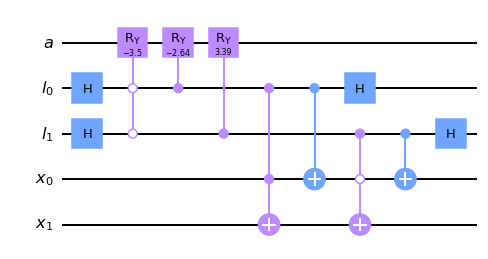

In [3]:
alpha = 0.75
beta = 0.25
gamma = - 0.125

num_sys_qubits = 2
qc = block_encoding(alpha, beta, gamma, num_sys_qubits, i=0, j=0, add_measurements=False)
qc.draw("mpl", fold=-1)

### Check $\langle 0^{\otimes 2} | \langle j | U_A | 0^{\otimes 2} \rangle | i \rangle = A_{ij} / 4$

In [4]:
num_aux_qubits = 3

for i in range(2 ** num_sys_qubits):
    qc = block_encoding(alpha, beta, gamma, num_sys_qubits, i=i, j=0, add_measurements=False)
    print(subspace_sv(num_sys_qubits, num_aux_qubits, Statevector(qc).data))

[ 0.1875   0.0625   0.      -0.03125]
[-0.03125  0.1875   0.0625   0.     ]
[ 0.      -0.03125  0.1875   0.0625 ]
[ 0.0625   0.      -0.03125  0.1875 ]


In [5]:
print(0.1875 * 4)
print(0.0625 * 4)
print(- 0.03125 * 4)

0.75
0.25
-0.125


## Banded circulant matrix
Block encoding of $A / 4$, where
$$
A = \begin{bmatrix}
\alpha & \gamma & 0 & 0 & 0 & 0 & 0 & \beta \\
\beta & \alpha & \gamma & 0 & 0 & 0 & 0 & 0 \\
0 & \beta & \alpha & \gamma & 0 & 0 & 0 & 0 \\
0 & 0 & \beta & \alpha & \gamma & 0 & 0 & 0 \\
0 & 0 & 0 & \beta & \alpha & \gamma & 0 & 0 \\
0 & 0 & 0 & 0 & \beta & \alpha & \gamma & 0 \\
0 & 0 & 0 & 0 & 0 & \beta & \alpha & \gamma \\
\gamma & 0 & 0 & 0 & 0 & 0 & \beta & \alpha
\end{bmatrix}
$$

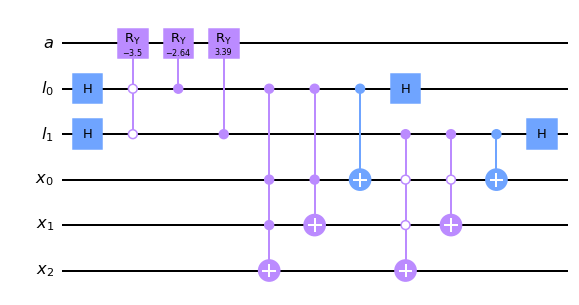

In [6]:
alpha = 0.75
beta = 0.25
gamma = - 0.125

num_sys_qubits = 3
qc = block_encoding(alpha, beta, gamma, num_sys_qubits, i=0, j=0, add_measurements=False)
qc.draw("mpl", fold=-1)

### Check $\langle 0^{\otimes 3} | \langle j | U_A | 0^{\otimes 3} \rangle | i \rangle = A_{ij} / 4$

In [7]:
for i in range(2 ** num_sys_qubits):
    qc = block_encoding(alpha, beta, gamma, num_sys_qubits, i=i, j=0, add_measurements=False)
    print(subspace_sv(num_sys_qubits, num_aux_qubits, Statevector(qc).data))

[ 0.1875   0.0625   0.       0.       0.       0.       0.      -0.03125]
[-0.03125  0.1875   0.0625   0.       0.       0.       0.       0.     ]
[ 0.      -0.03125  0.1875   0.0625   0.       0.       0.       0.     ]
[ 0.       0.      -0.03125  0.1875   0.0625   0.       0.       0.     ]
[ 0.       0.       0.      -0.03125  0.1875   0.0625   0.       0.     ]
[ 0.       0.       0.       0.      -0.03125  0.1875   0.0625   0.     ]
[ 0.       0.       0.       0.       0.      -0.03125  0.1875   0.0625 ]
[ 0.0625   0.       0.       0.       0.       0.      -0.03125  0.1875 ]


In [8]:
print(0.1875 * 4)
print(0.0625 * 4)
print(- 0.03125 * 4)

0.75
0.25
-0.125


## Banded circulant matrix
Block encoding of $A / 4$, where $A$ is $2^4 \times 2^4$ matrix.

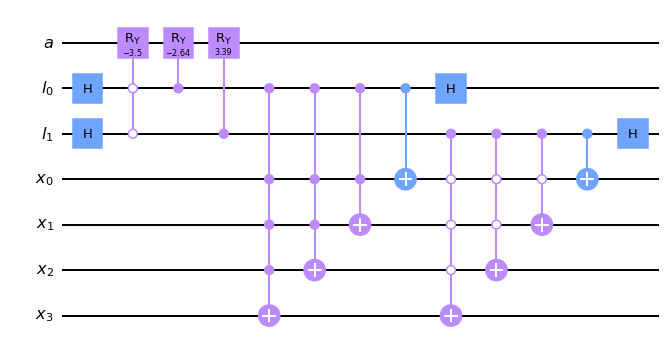

In [9]:
alpha = 0.75
beta = 0.25
gamma = - 0.125

num_sys_qubits = 4
qc = block_encoding(alpha, beta, gamma, num_sys_qubits, i=0, j=0, add_measurements=False)
qc.draw("mpl", fold=-1)

### Check $\langle 0^{\otimes 4} | \langle j | U_A | 0^{\otimes 4} \rangle | i \rangle = A_{ij} / 4$

In [10]:
for i in range(2 ** num_sys_qubits):
    qc = block_encoding(alpha, beta, gamma, num_sys_qubits, i=i, j=0, add_measurements=False)
    print(subspace_sv(num_sys_qubits, num_aux_qubits, Statevector(qc).data))

[ 0.1875   0.0625   0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.      -0.03125]
[-0.03125  0.1875   0.0625   0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.     ]
[ 0.      -0.03125  0.1875   0.0625   0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.     ]
[ 0.       0.      -0.03125  0.1875   0.0625   0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.     ]
[ 0.       0.       0.      -0.03125  0.1875   0.0625   0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.     ]
[ 0.       0.       0.       0.      -0.03125  0.1875   0.0625   0.
  0.       0.       0.       0.       0.       0.       0.       0.     ]
[ 0.       0.       0.       0.       0.      -0.03125  0.1875   0.0625
  0.       0.       0.       0.       0.       0.       0.       0.     ]
[ 

## Banded circulant Hermitian matrix ($s > 2$)
Block encoding of $A / s$, where $A^{\dagger} = A$ and $s = 4$

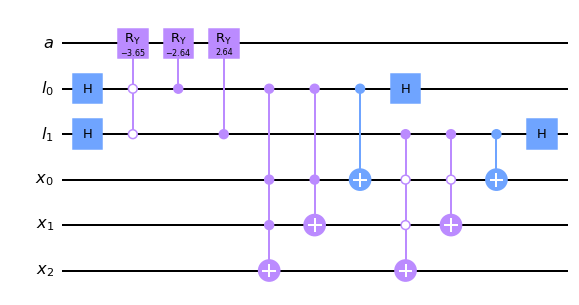

In [11]:
alpha = 0.75
beta = 0.25
gamma = 0.25

num_sys_qubits = 3
u = block_encoding(alpha, beta, gamma, num_sys_qubits, i=0, j=0, add_measurements=False)
u.draw("mpl", fold=-1)

### Signal oracle $U^{\prime} = SU$

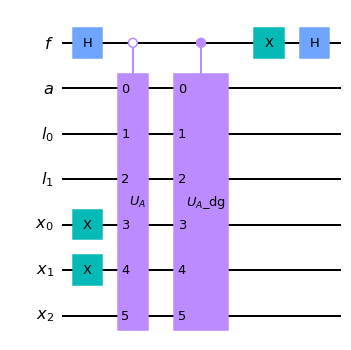

In [12]:
# signal operator
alpha = 0.75
beta = 0.25
gamma = 0.25

num_sys_qubits = 3
u = signal_oracle(alpha, beta, gamma, num_sys_qubits, i=3, j=0, add_measurements=False)
u.draw("mpl", fold=-1)

In [13]:
num_sys_qubits = 3
num_aux_qubits = 4

for i in range(2 ** num_sys_qubits):
    qc = signal_oracle(alpha, beta, gamma, num_sys_qubits, i=i, j=0, add_measurements=False)
    print(subspace_sv(num_sys_qubits, num_aux_qubits, Statevector(qc).data))

[ 1.87500000e-01  6.25000000e-02 -6.89706616e-18 -5.69730243e-18
  1.44307468e-17  1.75726487e-17 -2.96546361e-17  6.25000000e-02]
[ 6.25000000e-02  1.87500000e-01  6.25000000e-02 -8.78305635e-18
  2.10420957e-17  3.42714291e-18 -2.12587482e-17  3.01654228e-19]
[-2.96471432e-18  6.25000000e-02  1.87500000e-01  6.25000000e-02
  9.14948483e-18 -3.36731597e-18 -5.37676663e-17  1.33846558e-17]
[ 2.07444642e-17  4.92541997e-18  6.25000000e-02  1.87500000e-01
  6.25000000e-02 -3.07060474e-18  2.66671806e-17 -8.03327159e-17]
[ 3.48987315e-17  9.61757735e-18 -6.67358326e-18  6.25000000e-02
  1.87500000e-01  6.25000000e-02 -7.39220392e-18 -1.52127488e-17]
[ 2.92437331e-17 -1.65477098e-17 -2.30445372e-17 -1.72692739e-17
  6.25000000e-02  1.87500000e-01  6.25000000e-02 -1.43067630e-17]
[-2.31859976e-17  6.14813040e-18  5.04601773e-17 -5.08001128e-17
 -1.56575906e-17  6.25000000e-02  1.87500000e-01  6.25000000e-02]
[ 6.25000000e-02  3.58977495e-18 -1.11991044e-17  4.30281514e-17
 -1.64032748e-17  

In [14]:
print(0.1875 * 4)
print(0.0625 * 4)

0.75
0.25


### $\langle 0^{\otimes 4} | SUSU | 0^{\otimes 4} \rangle= I$

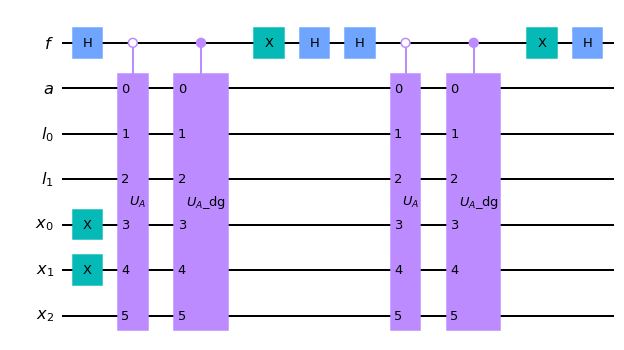

In [15]:
u = signal_oracle(alpha, beta, gamma, num_sys_qubits, i=3, j=0, add_measurements=False, rep=2)
u.draw("mpl", fold=-1)

In [16]:
for i in range(2 ** num_sys_qubits):
    qc = signal_oracle(alpha, beta, gamma, num_sys_qubits, i=i, j=0, add_measurements=False, rep=2)
    print(subspace_sv(num_sys_qubits, num_aux_qubits, Statevector(qc).data))

[ 1.00000000e+00 -1.83445699e-18  3.93180245e-17  4.59477364e-19
  6.39619963e-18  4.18080173e-18 -4.07903257e-17  1.12527447e-17]
[ 5.80672181e-17  1.00000000e+00  5.41741082e-18  4.12087371e-17
 -1.14162921e-17 -1.18095367e-16  5.17318335e-18 -6.96279360e-17]
[ 8.15137780e-18  8.00572577e-18  1.00000000e+00  4.71755346e-18
  2.54263051e-17  1.04982346e-17 -1.11360735e-16 -7.93961608e-18]
[ 3.32032681e-18 -6.41889882e-18 -4.15275524e-17  1.00000000e+00
  2.41273358e-17  4.47858050e-17 -1.49112138e-19  1.56670814e-16]
[-2.61214799e-17 -1.94738461e-18 -2.37836032e-18  2.07605652e-17
  1.00000000e+00 -7.44104638e-18 -7.43137506e-18 -7.32263339e-18]
[-1.65590772e-17 -6.53737914e-17  9.03624896e-18  6.33795073e-18
 -6.88595181e-18  1.00000000e+00  2.06653381e-17  5.47514453e-17]
[-3.12082486e-17 -5.41636884e-18 -9.31293670e-17  4.16772123e-19
  1.58570658e-17 -8.65865466e-18  1.00000000e+00 -1.66331756e-17]
[ 2.33759912e-17 -2.10498419e-17 -1.40203827e-17  2.14154493e-16
  5.19296690e-18  

### Unitary iterate $W = (2 | 0^{\otimes 4} \rangle \langle 0^{\otimes 4}| - I) S U_A$

In [17]:
alpha = 0.75
beta = 0.25
gamma = 0.25

num_sys_qubits = 3
w = unitary_iterate(alpha, beta, gamma, num_sys_qubits, i=3, j=0, global_phase=np.pi, add_measurements=False)
w.draw("mpl", fold=-1)

### Check $\langle 0^{\otimes 5} | \langle j | W_A | 0^{\otimes 5} \rangle | i \rangle = A_{ij} / 4$

In [18]:
num_sys_qubits = 3
num_aux_qubits = 5

for i in range(2 ** num_sys_qubits):
    qc = unitary_iterate(
        alpha, 
        beta, 
        gamma, 
        num_sys_qubits = 3, 
        i=i, 
        j=0, 
        global_phase=np.pi, 
        add_measurements=False,
    )
    print(subspace_sv(num_sys_qubits, num_aux_qubits, Statevector(qc).data))

[ 1.87500000e-01  6.25000000e-02 -2.40173964e-17  4.03706199e-17
 -1.73895388e-17  3.83382650e-17  1.68595304e-17  6.25000000e-02]
[ 6.25000000e-02  1.87500000e-01  6.25000000e-02  9.45184513e-18
  3.50431665e-17 -5.25771403e-17 -1.93285242e-17 -5.71631720e-18]
[-1.79211612e-17  6.25000000e-02  1.87500000e-01  6.25000000e-02
 -1.10821907e-17 -6.83676292e-18 -4.10804045e-17  8.60139987e-18]
[ 5.72721591e-18 -2.09037554e-17  6.25000000e-02  1.87500000e-01
  6.25000000e-02 -1.46982925e-17  2.37929967e-17  1.61144047e-17]
[ 3.07844593e-18 -2.57954382e-17  2.84462335e-18  6.25000000e-02
  1.87500000e-01  6.25000000e-02 -3.57146887e-17  2.62462661e-17]
[-4.50006794e-17  1.39478794e-18  1.19052598e-18 -2.57475139e-17
  6.25000000e-02  1.87500000e-01  6.25000000e-02 -1.17983208e-17]
[-2.54309612e-17  5.42958441e-18  4.35212834e-17 -3.40481410e-17
 -1.89351030e-18  6.25000000e-02  1.87500000e-01  6.25000000e-02]
[ 6.25000000e-02  6.14836845e-18  2.84019041e-17  1.52725758e-17
 -1.69985378e-17  

In [19]:
print(0.1875 * 4)
print(0.0625 * 4)

0.75
0.25
